In [15]:
# All the imports you will need in the whole lab
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import os, sys
import numpy as np 

import cv2

In [28]:
def get_lbp_hist(grayscale_img):
    # initialize the 2D matrix by zeros
    hist = np.zeros(256)
    # begin from 1 and end at size - 1 to ignore the borders
    for i in range (1, grayscale_img.shape[0] - 1):
        for j in range (1, grayscale_img.shape[1] - 1):
            b = 0b00000000
            if(grayscale_img[i - 1][j- 1] > grayscale_img[i][j]):
                b = b | 0b10000000
            if(grayscale_img[i - 1][j] > grayscale_img[i][j]):
                b = b | 0b01000000
            if(grayscale_img[i - 1][j+ 1] > grayscale_img[i][j]):
                b = b | 0b00100000
            if(grayscale_img[i][j + 1] > grayscale_img[i][j]):
                b = b | 0b00010000
            if(grayscale_img[i + 1][j + 1] > grayscale_img[i][j]):
                b = b | 0b00001000
            if(grayscale_img[i + 1][j] > grayscale_img[i][j]):
                b = b | 0b00000100
            if(grayscale_img[i + 1][j- 1] > grayscale_img[i][j]):
                b = b | 0b00000010
            if(grayscale_img[i][j- 1] > grayscale_img[i][j]):
                b = b | 0b00000001
            hist[b] = hist[b] + 1
    return hist

In [30]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

In [31]:
def lbp_calculated_pixel(img, x, y):  
    '''  
    64 | 128 |   1  
     ----------------  
    32 |   0 |   2  
    ----------------  
     16 |   8 |   4      
    '''      
    center = img[x][y]
    val_ar = []  
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right  
    val_ar.append(get_pixel(img, center, x, y+1))       # right  
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right  
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom  
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left  
    val_ar.append(get_pixel(img, center, x, y-1))       # left  
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left  
    val_ar.append(get_pixel(img, center, x-1, y))       # top  
            
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]  
    val = 0  
    for i in range(len(val_ar)):  
        val += val_ar[i] * power_val[i]  
    return val     

In [32]:
def train_lbph_input(images):
    #images_lbp=localBinaryPattern(images)
    print(images.shape)
    hist = []  
    face_resize = cv2.resize(images, (256, 256))  
    (s2,s3) = face_resize.shape        
    img_lbp = np.zeros((s2,s3,1), np.uint8)  
    io.imshow(face_resize)
    io.show()
    hist_lbp = get_lbp_hist(face_resize)
    hist.append(hist_lbp)
                #print(hist_lbp)  
         # images_lbp=localBinaryPattern(images)  
         #   
    return hist 
    

#LBPH.predict(Face) 

In [33]:
def train_lbph(images):
    #images_lbp=localBinaryPattern(images)
    #print(images.shape)
    s1 = images.shape[0]
    hist = []  
    for k in range(s1):
        for face in images[k]:
            face_resize = cv2.resize(face, (256, 256))  
            (s2,s3) = face_resize.shape
            img_lbp = np.zeros((s2,s3,1), np.uint8)   
            hist_lbp = get_lbp_hist(face_resize)  
            hist.append(hist_lbp)
                #print(hist_lbp)  
         # images_lbp=localBinaryPattern(images)  
         #   
    return hist 

In [49]:
#compares from training and coming image
def predict_lbph(input_image,recognizer,labels):
    #print('recognizer: ',recognizer.shape)
#     display('input_image.shape: ',input_image.shape)
    #print(input_image.shape)
    #print(recognizer.shape)
    s1,s2=input_image.shape[0],input_image.shape[1]
    d1=recognizer.shape[0]
    #(d1,d2,d3)=recognizer.shape
    temp=np.zeros((1,s1,s2))
    temp[0]=input_image
    input_histogramed=train_lbph_input(input_image)
    (minval,index,distance)=(200000,0,0)
    for i in range(d1):
        #distance=np.linalg.norm(recognizer[i,:]-input_histogramed[0])
        distance=cv2.compareHist(recognizer[i,:],input_histogramed[0],cv2.HISTCMP_CHISQR)
        #print("distance",distance,labels[i])
        if distance<minval:
            index=i
            minval=distance
    return (labels[index],minval)

In [50]:
#make preprocessing then uses this
def extract_faces_label(gray,save):
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades +  "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=4,
        minSize=(60, 60)
    )
    face_images=[]
    for (x, y, w, h) in faces:
        cv2.rectangle(gray, (x, y-15), (x+w, y+h), (0, 255, 0), 2)
        #cv2.putText(gray, 'mhmd' , (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN,1,(0, 255, 0))
        roi_color = gray[y-15:y + h, x:x + w]
        
        face_images.append(roi_color)
        if(save == 1):
            io.imsave('./training images/' + str(w) + str(h) + '_faces.jpg', roi_color)
    if(save == 1):
        io.imsave('faces_detected.jpg'+names.get_full_name(), image)

    return face_images

In [51]:
def training_lbp_label(train):
    (images, labels, names, id) = ([], [], {}, 0)
    for (subdirs, dirs, files) in os.walk('gray images'):
        for subdir in dirs:
            names[id] = subdir
            subjectpath = os.path.join('gray images', subdir)
            num=0
            for filename in os.listdir(subjectpath):
                path = subjectpath + '/' + filename
                lable = subdir
                images.append(cv2.imread(path, 0))
                labels.append(lable)
                num+=1

            id += 1
    (im_width, im_height) = (68, 68)

    # Create a np array from the two lists above
    (images_arr, labels_arr) = [np.array(lis) for lis in [images, labels]]
    if(train == 1):
        s1 = images_arr.shape[0]
        total_faces=[]
        for i in range(s1):
            faces = extract_faces_label(images_arr[i],0)   
            total_faces.append(faces)

        (faces_arr, labels_arr) = [np.array(lis) for lis in [total_faces, labels]]
        trained_face_recognizer=train_lbph(faces_arr) 
        print('done')
        np.save('trainedRec.npy',trained_face_recognizer)
    
    return labels


In [52]:
labels=training_lbp_label(1)

done


In [53]:
def test(imgfile):
    
    # save np.load
    np_load_old = np.load
    # modify the default parameters of np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    trained_face_recognizer=np.load('trainedRec.npy')
    # restore np.load for future normal usage
    np.load = np_load_old
    myimage=io.imread('images/'+imgfile)
    gray = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
    faces=extract_faces_label(gray,0)

    for face in faces:
#         display('face: ', face)
#         display('trained_face_recognizer: ', trained_face_recognizer)
        prediction=predict_lbph(face,trained_face_recognizer,labels)
        if (prediction[1])<3000:
            print(prediction[0])
            cv2.putText(myimage,'recognized - %.0f' % (prediction[1]),(10, 10), cv2.FONT_HERSHEY_PLAIN,1,(0, 255, 0))
            print('recognized, horaaaaaay!')
        else:
            cv2.putText(myimage,'not recognized',(10, 10), cv2.FONT_HERSHEY_PLAIN,1,(0, 255, 0))
            print('Ooops!not recognized :(')
            

(433, 418)


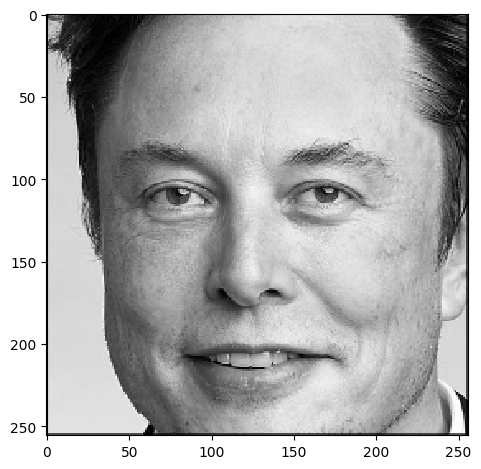

IndexError: list index out of range

In [59]:
test('Elon_Musk.jpg')